In [177]:
# Notebook for smc sampler 
from __future__ import print_function
from __future__ import division
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
sys.path.append("/home/alex/python_programming/help_functions")
sys.path.append("/home/alex/Dropbox/smc_hmc/python_smchmc")
from smc_sampler_functions.functions_smc_help import sequence_distributions

from help.f_rand_seq_gen import random_sequence_qmc, random_sequence_rqmc, random_sequence_mc
import numpy as np
from functools import partial


import sys
sys.path.append("../help")
from help import resampling
from help import dichotomic_search
import inspect
import time
import copy
import pickle
import datetime
import os


#from help.gaussian_densities_etc import gaussian_vectorized
from help.gaussian_densities_etc import gaussian_vectorized
from smc_sampler_functions.functions_smc_help import hilbert_sampling
from smc_sampler_functions.functions_smc_is_main import smc_sampler_is_qmc
from smc_sampler_functions.functions_smc_main import smc_sampler
# define the parameters
dim = 20
N_particles = 2**10
T_time = 50
move_steps = 10
ESStarget = 0.9
#rs = np.random.seed(1)
targetmean = np.ones(dim)*0.1
targetvariance = np.eye(dim)*0.8
#targetvariance[0,0] = 0.1
#targetvariance[-1,-1] = 2
targetvariance_inv = np.linalg.inv(targetvariance)
l_targetvariance_inv = np.linalg.cholesky(targetvariance_inv)
parameters = {'dim' : dim, 
              'N_particles' : N_particles, 
              'targetmean': targetmean, 
              'targetvariance':targetvariance,
              'logdet_targetvariance' : np.linalg.slogdet(targetvariance)[1],
              'targetvariance_inv':targetvariance_inv,
              'l_targetvariance_inv':l_targetvariance_inv,
              'df' : 10,
              'T_time' : T_time,
              'autotempering' : True,
              'ESStarget': ESStarget,
              'adaptive_covariance' : True,
              'quantile_test': 0.9
             }


# define the target distributions
from smc_sampler_functions.target_distributions import priorlogdens, priorgradlogdens, priorsampler
from smc_sampler_functions.target_distributions import targetlogdens_normal, targetgradlogdens_normal
from smc_sampler_functions.target_distributions import targetlogdens_student, targetgradlogdens_student
from smc_sampler_functions.target_distributions import targetlogdens_banana, targetgradlogdens_banana
from smc_sampler_functions.target_distributions import targetlogdens_warped, targetgradlogdens_warped
from smc_sampler_functions.target_distributions import targetlogdens_logistic, targetgradlogdens_logistic, f_dict_logistic_regression
from smc_sampler_functions.target_distributions import targetlogdens_normal_mix, targetgradlogdens_normal_mix


priordistribution = {'logdensity' : priorlogdens, 'gradlogdensity' : priorgradlogdens, 'priorsampler': priorsampler}
targetdistribution = {'logdensity' : targetlogdens_normal, 'gradlogdensity' : targetgradlogdens_normal, 'target_name': 'normal'}
#targetdistribution = {'logdensity' : targetlogdens_student, 'gradlogdensity' : targetgradlogdens_student, 'target_name': 'student_model'}
#targetdistribution = {'logdensity' : targetlogdens_logistic, 'gradlogdensity' : targetgradlogdens_logistic, 'target_name': 'logistic'}
#targetdistribution = {'logdensity' : targetlogdens_warped, 'gradlogdensity' : targetgradlogdens_warped, 'target_name': 'warped_model'}
#targetdistribution = {'logdensity' : targetlogdens_normal_mix, 'gradlogdensity' : targetgradlogdens_normal_mix, 'target_name': 'normal_mix'}

#parameters_logistic = f_dict_logistic_regression(dim)
#import ipdb; ipdb.set_trace()
#parameters.update(parameters_logistic)


temperedist = sequence_distributions(parameters, priordistribution, targetdistribution)

# prepare the kernels and specify parameters
from smc_sampler_functions.proposal_kernels import proposalmala, proposalrw, proposalhmc, proposalhmc_is
from smc_sampler_functions.functions_smc_main import smc_sampler


epsilon_hmc = 0.005
verbose = False
move_steps_hmc = 2
hmcdict = {'proposalkernel_tune': proposalhmc,
                      'proposalkernel_sample': proposalhmc,
                      'proposalname' : 'HMC',
                      'target_probability' : 0.9,
                      'covariance_matrix' : np.eye(dim), 
                      'L_steps' : 100,
                      'epsilon' : np.array([epsilon_hmc]),
                      'epsilon_max' : np.array([epsilon_hmc]),
                      'accept_reject' : True,
                      'tune_kernel': True,
                      'sample_eps_L' : True,
                      'parallelize' : False,
                      'verbose' : verbose,
                      'move_steps': 10,
                      'mean_L' : False
                      }

hmcdict_is_mc = {'proposalkernel_tune': proposalhmc_is,
                      'proposalkernel_sample': proposalhmc_is,
                      'proposalname' : 'HMC IS MC',
                      'target_probability' : 0.95,
                      'covariance_matrix' : np.eye(dim), 
                      'L_steps' : 50,
                      'epsilon' : np.array([epsilon_hmc]),
                      'epsilon_max' : np.array([epsilon_hmc]),
                      'accept_reject' : False,
                      'tune_kernel': True,
                      'sample_eps_L' : True,
                      'parallelize' : False,
                      'verbose' : verbose,
                      'move_steps': 1,
                      'mean_L' : True,
                      'unif_sampler' : random_sequence_mc, 
                      'trajectory_selector_energy' : True
                      }
hmcdict_is_qmc = copy.copy(hmcdict_is_mc)
hmcdict_is_qmc["unif_sampler"] = random_sequence_rqmc
hmcdict_is_qmc["proposalname"] = 'HMC IS QMC'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Starting sqmc is sampler
Now runing smc sampler with HMC IS QMC kernel
ERROR: outside 0 1 ! ure 1.0, current ESS 0.999986955551081262
Sampler ended at time 9 after 9.11531996727 seconds 

Starting sqmc is sampler
Now runing smc sampler with HMC IS MC kernel
Sampler ended at time 9 after 7.5378780365 seconds 45493725375



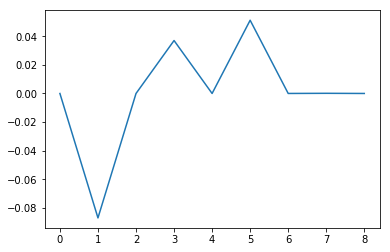

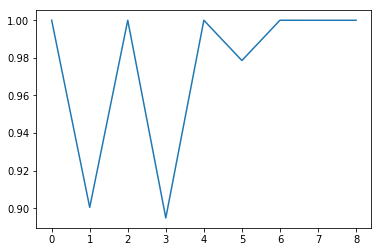

In [183]:
res_qmc = smc_sampler_is_qmc(temperedist, parameters, hmcdict_is_qmc)
res_mc = smc_sampler_is_qmc(temperedist, parameters, hmcdict_is_mc)
plt.plot(res_qmc['Z_list']); plt.show()
plt.plot(res_qmc['ESS_list']); plt.show()

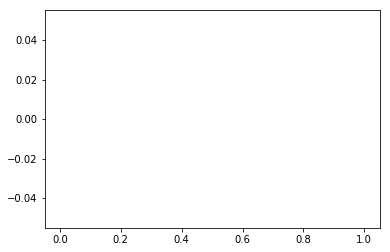

In [184]:
plt.hist([res['test_statistic'] for res in res_qmc['test_dict_list']], alpha=0.5)
plt.hist([res['test_statistic'] for res in res_mc['test_dict_list']], alpha=0.5)
#plt.hist([res['test_statistic'] for res in res_mcmc['test_dict_list']], alpha=0.5)
plt.show()

In [185]:

[res['epsilon'].mean() for res in res_qmc['perf_list']], [res['L'] for res in res_qmc['perf_list']]

([0.0050000000000000001,
  0.0038402229044293061,
  0.0038402229044293061,
  0.13680708078620674,
  0.13680708078620674,
  0.13590778922748653,
  0.13590778922748653,
  0.14169140777511238,
  0.14169140777511238],
 [50, 33, 33, 21, 21, 22, 22, 21, 21])

In [186]:
qmc_list = []
mc_list = []
mcmc_list = []
for m in range(20):
    print(m)
    res_qmc = smc_sampler_is_qmc(temperedist, parameters, hmcdict_is_qmc)
    res_mc = smc_sampler_is_qmc(temperedist, parameters, hmcdict_is_mc)
    #res_mcmc = smc_sampler(temperedist, parameters, hmcdict)
    qmc_list.append(res_qmc)
    mc_list.append(res_mc)
    #mcmc_list.append(res_mcmc)


0
Starting sqmc is sampler
Now runing smc sampler with HMC IS QMC kernel
Sampler ended at time 9 after 7.05706596375 seconds 108334002

Starting sqmc is sampler
Now runing smc sampler with HMC IS MC kernel
Sampler ended at time 9 after 6.76473498344 seconds 479494334

1
Starting sqmc is sampler
Now runing smc sampler with HMC IS QMC kernel
Sampler ended at time 9 after 7.47413301468 seconds 8562623979

Starting sqmc is sampler
Now runing smc sampler with HMC IS MC kernel
Sampler ended at time 9 after 7.63816690445 seconds 406379966

2
Starting sqmc is sampler
Now runing smc sampler with HMC IS QMC kernel
Sampler ended at time 9 after 8.45532107353 seconds 8221944526

Starting sqmc is sampler
Now runing smc sampler with HMC IS MC kernel
Sampler ended at time 9 after 9.2048830986 seconds 32238606652

3
Starting sqmc is sampler
Now runing smc sampler with HMC IS QMC kernel
Sampler ended at time 9 after 9.44971990585 seconds 0931075

Starting sqmc is sampler
Now runing smc sampler with HMC

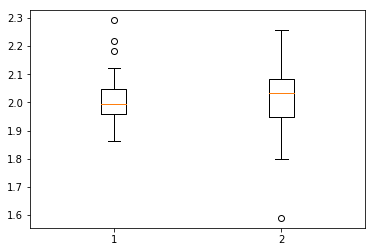

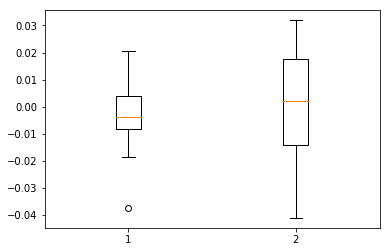

2.48060309779
1.66399274638


In [187]:
Z_list_qmc = [np.sum(res['Z_list']) for res in qmc_list]
Z_list_mc = [np.sum(res['Z_list']) for res in mc_list]

mean_list_qmc = [res['particles_resampled'].mean(axis=0) for res in qmc_list]
mean_list_mc = [res['particles_resampled'].mean(axis=0) for res in mc_list]

data_mean = [np.array(mean_list_qmc).sum(axis=1), np.array(mean_list_mc).sum(axis=1)]
data_norm = [Z_list_qmc, Z_list_mc]
#plt.subplot(121)
plt.boxplot(data_mean)
plt.savefig('boxplot_cum_mean_dim%s_%s.png'%(dim, targetdistribution['target_name']))
plt.show()
#plt.subplot(122)
plt.boxplot(data_norm)
plt.savefig('boxplot_norm_constant_dim%s_%s.png'%(dim, targetdistribution['target_name']))
plt.show()
#print((np.array(Z_list_qmc)**2).mean(), (np.array(Z_list_mc)**2).mean(), (np.array(Z_list_mcmc)**2).mean() )
#print(((np.array(mean_list_qmc).sum(axis=1)-targetmean.sum())**2).sum(), ((np.array(mean_list_mc).sum(axis=1)-targetmean.sum())**2).sum(), ((np.array(mean_list_mcmc).sum(axis=1)-targetmean.sum())**2).sum())
#print(np.array(Z_list_qmc).var(), np.array(Z_list_mc).var(), np.array(Z_list_mcmc).var())
print(np.array(Z_list_mc).var()/np.array(Z_list_qmc).var())
print(np.array(mean_list_mc).sum(axis=1).var()/np.array(mean_list_qmc).sum(axis=1).var())
#print(np.array(mean_list_qmc).sum(axis=1).var(), np.array(mean_list_mc).sum(axis=1).var(), np.array(mean_list_mcmc).sum(axis=1).var())
#print(np.array(Z_list_qmc)).var(), (np.array(Z_list_mc)).var(), (np.array(Z_list_mcmc)).var() 
#np.array(mean_list_qmc).sum(axis=1).var(), (np.array(mean_list_mc).sum(axis=1)).var(), (np.array(mean_list_mcmc).sum(axis=1)).var()

In [ ]:
Z_list_qmc = [np.sum(res['Z_list']) for res in qmc_list]
Z_list_mc = [np.sum(res['Z_list']) for res in mc_list]
Z_list_mcmc = [np.sum(res['Z_list']) for res in mcmc_list]

mean_list_qmc = [res['particles_resampled'].mean(axis=0) for res in qmc_list]
mean_list_mc = [res['particles_resampled'].mean(axis=0) for res in mc_list]
mean_list_mcmc = [res['particles_resampled'].mean(axis=0) for res in mcmc_list]

data_mean = [np.array(mean_list_qmc).sum(axis=1), np.array(mean_list_mc).sum(axis=1), np.array(mean_list_mcmc).sum(axis=1)]
data_norm = [Z_list_qmc, Z_list_mc, Z_list_mcmc]
#plt.subplot(121)
plt.boxplot(data_mean)
plt.savefig('boxplot_cum_mean_dim%s_%s.png'%(dim, targetdistribution['target_name']))
plt.show()
#plt.subplot(122)
plt.boxplot(data_norm)
plt.savefig('boxplot_norm_constant_dim%s_%s.png'%(dim, targetdistribution['target_name']))
plt.show()
#print((np.array(Z_list_qmc)**2).mean(), (np.array(Z_list_mc)**2).mean(), (np.array(Z_list_mcmc)**2).mean() )
#print(((np.array(mean_list_qmc).sum(axis=1)-targetmean.sum())**2).sum(), ((np.array(mean_list_mc).sum(axis=1)-targetmean.sum())**2).sum(), ((np.array(mean_list_mcmc).sum(axis=1)-targetmean.sum())**2).sum())
print(np.array(Z_list_qmc).var(), np.array(Z_list_mc).var(), np.array(Z_list_mcmc).var())
print(np.array(mean_list_qmc).sum(axis=1).var(), np.array(mean_list_mc).sum(axis=1).var(), np.array(mean_list_mcmc).sum(axis=1).var())
#print(np.array(Z_list_qmc)).var(), (np.array(Z_list_mc)).var(), (np.array(Z_list_mcmc)).var() 
#np.array(mean_list_qmc).sum(axis=1).var(), (np.array(mean_list_mc).sum(axis=1)).var(), (np.array(mean_list_mcmc).sum(axis=1)).var()

In [ ]:
plt.plot(res_qmc['temp_list'], res_qmc['ESS_list'] )
plt.plot(res_qmc['temp_list'], res_qmc['Z_list'])
plt.plot(res_mc['temp_list'], res_mc['ESS_list'] )
plt.plot(res_mc['temp_list'], res_mc['Z_list']); plt.show()
parameters
np.sum(res_qmc['Z_list']), np.sum(res_mc['Z_list']), np.sum(res_mcmc['Z_list'])


### IS version based on HMC flow
We sample on the extended state space $(x, p)$, where $x$ is the position and $p$ the momentum.
We target the distribution $\mu_t = \pi_t \times g$. At time $t-1$, 
$\theta = (x, p)$ is distributed according $\mu_{t-1}$. We use the Hamiltonian flow $\Phi$ in order to move 
$(x, p)$ to $(\tilde{x}, \tilde{p}) = \tilde{ \theta }$. 
The weight is based on the importance sampling weight
$$
w(\tilde{\theta},\theta) = \frac{\mu_t(\tilde{x}, \tilde{p})}{\mu_{t-1}(x,p)}.
$$
This is because of 
$$
\mu_{t-1}(\theta) = \mu_{t-1}(\Phi^{-1}(\tilde{\theta})) \times \det | \Phi^{-1} |
$$
and $\det | \Phi^{-1} | = 1$, when we consider the HMC flow to be a change of variables.
In case of a move step (targeting the same distribution) we get 
$$
w(\tilde{\theta},\theta) = \frac{\mu_{t-1}(\tilde{x}, \tilde{p})}{\mu_{t-1}(x,p)}.
$$
for the weights.

In [ ]:
plt.scatter(x=res_mc['particles_resampled'][:,0], y=res_mc['particles_resampled'][:,1]); plt.show()

In [ ]:
print(np.var(summary_particles_norm_qmc))
print(np.var(summary_particles_norm_mc))
plt.plot(np.array(summary_particles_mean_mc).var(axis=0))
plt.plot(np.array(summary_particles_mean_qmc).var(axis=0)); plt.show()
np.array(summary_particles_mean_mc).shape

In [ ]:
N_particles = 1000
u_randomness = random_sequence_rqmc(dim*2, 0, N_particles)
particles_initial = gaussian_vectorized(u_randomness[:, :dim])
temp = 1.
particles, perf_dict = proposalhmc_is(particles_initial, u_randomness[:, dim:], hmcdict_is_mc, temperedist, temp)
#particles, perf_dict = proposalhmc(particles_initial, hmcdict_is, temperedist, temp)
weights_log = (temperedist.logdensity(particles,temp)-perf_dict['energy_kinetic'][:,-1]-temperedist.logdensity(particles_initial,0)+perf_dict['energy_kinetic'][:,0])
#weights_log = (temperedist.logdensity(particles,temp)-temperedist.logdensity(particles_initial,0))
print(np.exp(weights_log).mean())
#import pdb; pdb.set_trace()
weights_normalized = np.exp(weights_log)/np.exp(weights_log).sum()
ESS = 1/(weights_normalized**2).sum()
print(ESS)

u_randomness = random_sequence_rqmc(dim+1, 0, N_particles)
# hilbert sampling
#ancestors = resampling.multinomial_resample(weights_normalized)
#particles_resampled = particles[ancestors,:]
particles_resampled, weights_normalized_new, u_randomness_ordered = hilbert_sampling(particles, weights_normalized, u_randomness)
plt.scatter(x=particles_initial[:,0], y=particles_initial[:,1], label="init")
plt.scatter(x=particles[:,0], y=particles[:,1], label="moved")
plt.scatter(x=particles_resampled[:,0], y=particles_resampled[:,1], label="resampled"); plt.legend()
plt.show()
print(particles_resampled.mean(axis=0))
print(particles.mean(axis=0))
print(parameters['targetmean'])

In [ ]:
perf_dict['trajectory_particles'][0][:,:,0]-particles_initial


In [178]:
def repeat_is_sampling(random_sequence, N_particles_list):
    dict_particles = {str(N_particles): [] for N_particles in N_particles_list}
    m_rep = 20
    for N_particles in N_particles_list:
        array_means = np.zeros((m_rep, dim, hmcdict_is_mc['L_steps']+1))
        #list_means_resampled = []
        array_norm_const = np.zeros((m_rep, 1, hmcdict_is_mc['L_steps']+1))
        for m in range(m_rep):
            u_randomness = random_sequence(dim*2, 0, N_particles)
            particles_initial = gaussian_vectorized(u_randomness[:, :dim])
            temp = 1.
            particles, perf_dict = proposalhmc_is(particles_initial, u_randomness[:, dim:], hmcdict_is_mc, temperedist, temp)
            for k_step in range(hmcdict_is_mc['L_steps']+1):
                #particles, perf_dict = proposalhmc(particles_initial, hmcdict_is, temperedist, temp)
                particles_current = perf_dict['trajectory_particles'][0][:,:,k_step]
                weights_log = (temperedist.logdensity(particles_current,temp)-perf_dict['energy_kinetic'][:,k_step]-temperedist.logdensity(particles_initial,0)+perf_dict['energy_kinetic'][:,0])
                weights_normalized = np.exp(weights_log)/np.exp(weights_log).sum()
                array_means[m, :, k_step] = (particles_current*weights_normalized[:,np.newaxis]).sum(axis=0)

                ESS = 1/(weights_normalized**2).sum()
                #print(ESS)
                array_norm_const[m, :, k_step] = np.exp(weights_log).mean()
        dict_particles[str(N_particles)].append({'means': array_means, 'norm_const':array_norm_const})

            #u_randomness = random_sequence(dim+1, 0, N_particles)
            # hilbert sampling
            #ancestors = resampling.multinomial_resample(weights_normalized)
            #particles_resampled = particles[ancestors,:]
            #particles_resampled, weights_normalized_new, u_randomness_ordered = hilbert_sampling(particles, weights_normalized, u_randomness)
            #list_means_resampled.append(particles_resampled.mean())
    return(dict_particles)

In [179]:
N_particles_list = [50, 100, 200, 500, 1000, 2000, 5000]#, 10000, 20000]
dict_particles = repeat_is_sampling(random_sequence_mc, N_particles_list)

In [104]:
[dict_particles[str(N_particles)][0]['norm_const'].var(axis=0)[0,-1] for N_particles in N_particles_list]

[0.053271598611749474,
 0.028160848407543522,
 0.025622939195310716,
 0.0031497952398221222,
 0.002022093143421326,
 0.0010565290230824371,
 0.00071356991315099573]

In [180]:
dict_particles_qmc = repeat_is_sampling(random_sequence_rqmc, N_particles_list)

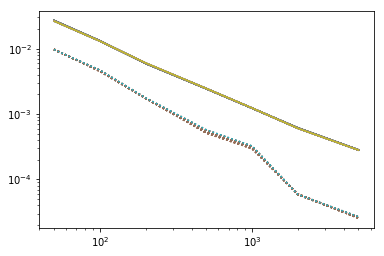

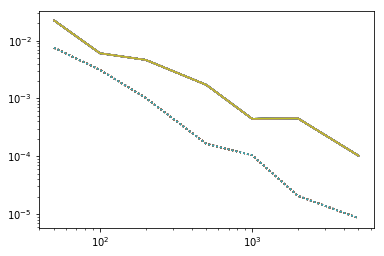

In [181]:
ind = 0
for ind in range(0,hmcdict_is_mc['L_steps']):
    plt.plot(N_particles_list, [((dict_particles[str(N_particles)][0]['means']-targetmean[np.newaxis,:,np.newaxis])**2).mean(axis=0).mean(axis=0)[ind] for N_particles in N_particles_list])
    plt.plot(N_particles_list, [((dict_particles_qmc[str(N_particles)][0]['means']-targetmean[np.newaxis,:,np.newaxis])**2).mean(axis=0).mean(axis=0)[ind] for N_particles in N_particles_list], linestyle=":")
plt.yscale('log'); plt.xscale('log')
plt.show()

for ind in range(0,hmcdict_is_mc['L_steps']):
    plt.plot(N_particles_list, [((dict_particles[str(N_particles)][0]['norm_const']-1)**2).mean(axis=0)[0,ind] for N_particles in N_particles_list])
    plt.plot(N_particles_list, [((dict_particles_qmc[str(N_particles)][0]['norm_const']-1)**2).mean(axis=0)[0,ind] for N_particles in N_particles_list], linestyle=":")
plt.yscale('log'); plt.xscale('log')
plt.show()


In [182]:
print(np.log(((dict_particles['5000'][0]['means']-targetmean[np.newaxis,:,np.newaxis])**2).mean(axis=0).mean(axis=0)[[0,-1]]))
print(np.log(((dict_particles_qmc['5000'][0]['means']-targetmean[np.newaxis,:,np.newaxis])**2).mean(axis=0).mean(axis=0)[[0,-1]]))
print (((dict_particles['5000'][0]['means']-targetmean[np.newaxis,:,np.newaxis])**2).mean(axis=0).mean(axis=0)/((dict_particles_qmc['5000'][0]['means']-targetmean[np.newaxis,:,np.newaxis])**2).mean(axis=0).mean(axis=0))
#((dict_particles['5000'][0]['means']-targetmean[np.newaxis,:,np.newaxis])**2).mean(axis=0).mean(axis=0)[0,:]/((dict_particles_qmc['5000'][0]['means']-targetmean[np.newaxis,:,np.newaxis])**2).mean(axis=0).mean(axis=0)[0,:]

print(np.log(((dict_particles['5000'][0]['norm_const']-1)**2).mean(axis=0).mean(axis=0)[[0,-1]]))
print(np.log(((dict_particles_qmc['5000'][0]['norm_const']-1)**2).mean(axis=0).mean(axis=0)[[0,-1]]))

[-8.16900577 -8.17842828]
[-10.57172156 -10.51903071]
[ 11.05315368  11.05233421  11.05095946  11.04902963  11.04654519
  11.04350682  11.03991547  11.03577231  11.03107875  11.02583645
  11.0200473   11.01371341  11.00683714  10.99942107  10.99146801
  10.982981    10.9739633   10.96441838  10.95434993  10.94376185
  10.93265827  10.9210435   10.90892204  10.89629863  10.88317817
  10.86956574  10.85546663  10.84088629  10.82583035  10.8103046   10.794315
  10.77786767  10.76096888  10.74362503  10.72584268  10.70762853
  10.68898938  10.66993218  10.65046399  10.63059199  10.61032343
  10.58966571  10.56862629  10.54721274  10.52543268  10.50329383
  10.48080398  10.45797098  10.43480274  10.41130721  10.38749239]
[-9.18917324 -9.18917981]
[-11.67870547 -11.67871904]


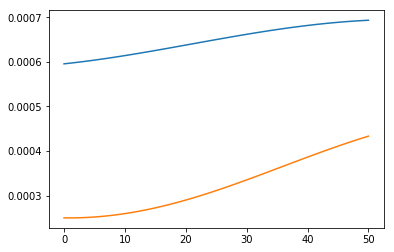

(20, 50, 51)

In [136]:
plt.plot(dict_particles['5000'][0]['means'].var(axis=0).mean(axis=0))
plt.plot(dict_particles_qmc['5000'][0]['means'].var(axis=0).mean(axis=0))
plt.show()
dict_particles['5000'][0]['means'].shape

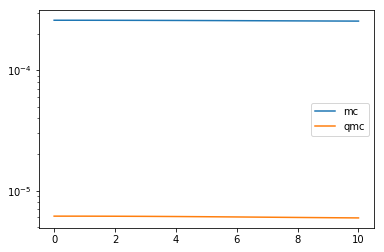

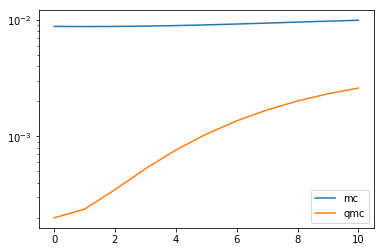

In [8]:
array_means[:,:,:].var(axis=0).sum(axis=0)
array_norm_const_qmc.var(axis=0)
plt.plot(array_norm_const.var(axis=0).flatten(), label="mc") 
plt.plot(array_norm_const_qmc.var(axis=0).flatten(), label="qmc")
plt.yscale('log')
plt.legend(); plt.show()

array_means[:,:,:].var(axis=0).sum(axis=0)
plt.plot((array_means[:,:,:]).var(axis=0).sum(axis=0).flatten(), label="mc") 
plt.plot((array_means_qmc[:,:,:]).var(axis=0).sum(axis=0).flatten(), label="qmc")
plt.yscale('log')
plt.legend(); plt.show()


In [ ]:
plt.boxplot([list_norm_const, list_norm_const_qmc]); plt.show()